# 프로젝트 소개 - 개인 : 퍼셉트론 수의 영향 알아보기

MNIST fashion data를 가지고 다양한 조건으로 최상의 분류모델 찾기
- 데이터셋 : fashion mnist
- 피쳐개수 : 28X28 784개

- batch_size = 50
- epoch = 30
- 조기 종료 조건 : F1 기준 갱신 5번 이하
- learning_rate = default
- 최적화 함수 → Adam
- 배치 정규화 → 각 레이어마다
- 가중치 초기화 → He
- train : validation = 6 : 1
- test는 팀원 개인 글씨

## 1. 모듈 로딩 

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch # torch 기본 모듈로 텐서 기본 함수들 
import torch.nn as nn # linear Regression 기능의 클래스 Linear
import torch.nn.functional as F # 손실함수를 위함
import torch.optim as optim # 최적화를 위함

## 2. 데이터 준비

In [2]:
fashion_db = 'fashion-mnist'

fashion_data = fetch_openml(name = fashion_db, parser='auto')

In [27]:
# 데이터 확인 
feature = fashion_data['data']
target = fashion_data['target']

In [28]:
# 데이터 피쳐와 타겟 개수 확인 
print(f"feares: {feature.shape}, {feature.ndim}D")
print(f"target: {target.shape}, {target.ndim}D")

feares: (70000, 784), 2D
target: (70000,), 1D


## 3. 데이터 가공 및 전처리
- 결측치 없음
- 이상치 없음
- 중복값 없음 
- 정규화 : 피쳐 정규화 / 타겟 정규화

In [29]:
# 이미지 데이터 정규화
norm_feature = feature/255
norm_feature

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.121569,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.105882,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# 타겟이 서로 관련성이 없으니 One-Hot 인코딩으로 변환
# one-hot ver1
# import pandas as pd
# pd.get_dummies(target)

In [31]:
# one-hot ver2
# from sklearn.preprocessing import OneHotEncoder
# 
# targetDF = target.to_frame()
# 
# # parse_output=False : ndarray 타입으로 반환
# ohEncoder = OneHotEncoder(sparse_output=False)
# norm_target = ohEncoder.fit_transform(targetDF) # one-hot encoder 안에는 꼭 2차원 
# # 라벨 인코딩은 정수로 바꿔줌 
# norm_target

In [97]:
# one-hot encoding : scatter_
idx = torch.IntTensor(target.astype("int")).type(torch.int64).unsqueeze(1)

y_one_hot = torch.zeros(target.shape[0],10)
y_one_hot = y_one_hot.scatter_(1, idx, 1).type(torch.int64) # 차원, 1.0이 들어갈 자리 인덱스, 채울 숫자

## 4. 데이터 셋 준비
- 텐서화 시키기
- 데이터 셋 준비 : 훈련용 60000, 테스트용 10000
- 학습 방법 : 지도 학습 - 이진 분류 (softmax->but cross_entropy가 다 갖고 있음)
- 최적화 방법 : 경사하강법 기반의 방법 (Adam, SDG, )
- 손실함수 : 이진분류 손실 계산 함수(cross_entropy)

In [83]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [101]:
# 사용자 정의 DataSet Class
# 데이터의 텐서변환
class DLDataset(Dataset): # torch.utils.data.Dataset을 부모로 두는 class 생성
    # 초기화 함수
    def __init__(self, x_data, y_data):
        # print(y_data.dtype)
        super().__init__()
        
        # x 데이터 => ndarray
        if isinstance(x_data, torch.Tensor):
            pass
        else:
            x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data # 데이터 프레임이라면 valuse로 어레이 뽑아줘야함 
            
        # y 데이터 => ndarray
        if isinstance(y_data, torch.Tensor):
            pass
        else:
            y_data = y_data.values if isinstance(y_data, pd.DataFrame) else y_data 
        # ndarray에서 tensor로 변환 
        
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.LongTensor(y_data) 
        # print("[target & feature SHAPE]", self.target.shape, self.target.ndim)
    
    # 데이터셋의 개수 체크 함수
    def __len__(self):
        return self.target.shape[0]
    
    # 특정 인덱스 데이터 + 라벨 반환 callback function 
    def __getitem__(self, index):
        return self.feature[index], self.target[index] # 둘 다 튜플로 출동 

In [102]:
# featureNP = norm_feature.values

In [103]:
# targetNP = y_one_hot.numpy()

In [118]:
my_dataset = DLDataset(norm_feature, y_one_hot) # numpy, numpy

## 5. 데이터 나누기 -> train : validation = 6 : 1
- test data는 직접 그린 그림으로 사용

In [120]:
from torch.utils.data import random_split

seed = torch.Generator().manual_seed(42)
trainDS, validDS = random_split(my_dataset, [60000, 10000], generator=seed) 

print(f"trainDS => {len(trainDS)}개\nvalidDS => {len(validDS)}개")

trainDS => 60000개
validDS => 10000개


In [122]:
# DataLoader 생성
BATCH_SIZE = 50
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE, drop_last=False)
validDL = DataLoader(validDS, batch_size=BATCH_SIZE, drop_last=False)

print(f"나눠진 배치 개수\ntrainDL => {len(trainDL)}\nvalidDL => {len(validDL)}") # -> 배치가 50이라서 남는 데이터는 없음 

나눠진 배치 개수
trainDL => 1200
validDL => 200


## 6. 학습
- 조기 종료 조건 넣기
- 코드 좀 더 유연하게 수정하기
- 배치 정규화 -> 각 레이어마다
- 가중치 초기화 -> He

### 6-1 모델 생성

In [129]:
temp_feature, temp_label = next(iter(trainDL))

In [132]:
temp_feature.shape[1], temp_label.shape[1] # 각각의 1번 요소를 뽑으면 IN_DIM, OUT_DIM

(784, 10)

In [135]:
# MyModel 클래스 생성 : 내 미션은 퍼셉트론 수 영향 알아보기 
class MyModel(nn.Module):
    
    # 모델 구성 요소 초기화 
    def __init__(self, in_dim, out_dim, layer_num):
        super().__init__()
        self.layer_num = layer_num
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.layers = nn.ModuleList()  # ModuleList에 layer 담기
        
        # 은닉층과 활성화 함수 추가
        for i in range(self.layer_num):
            self.layers.append(nn.Linear(in_dim, out_dim))  # 선형 레이어 추가
            self.layers.append(nn.ReLU())  # ReLU 활성화 함수 추가
            in_dim = out_dim  # 다음 레이어의 입력 차원을 현재 출력 차원으로 설정
            
        # 출력층 추가
        self.layers.append(nn.Linear(out_dim, out_dim))
        
    def forward(self, x):
        # 각 레이어를 차례로 통과시킴
        for layer in self.layers:
            x = layer(x)
        return x

### 6-2. 학습 함수, 예측 함수 생성, 실행디바이스, 모델, 최적화, 손실함수, 학습 횟수

In [139]:
# 실행 디바이스 설정
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # GPU있으면 쓰고 없으면 cpu로

In [140]:
# 모델 인스턴스 생성
IN_DIM = temp_feature.shape[1] # 입력 피쳐 수
OUT_DIM = temp_label.shape[1] # 출력 피쳐 수
HIDDEN_NUM = 0 # 히든 레이어 개수 나는 0개!! 퍼셉트론 수 조절 하기  

model = MyModel(IN_DIM, OUT_DIM, HIDDEN_NUM+2).to(DEVICE)

In [141]:
perceptron_nums = np.linspace(IN_DIM, OUT_DIM, HIDDEN_NUM+2, dtype=int)

In [142]:
# 손실함수 인스턴스 생성
LOSS_FN = nn.CrossEntropyLoss().to(DEVICE) # 다중분류니까

# 최적화 인스턴스 생성
OPTIMIZER = optim.Adam(model.parameters()) # lr = default 사용

# 반복 횟수
EPOCHS = 30

In [143]:
import torchmetrics.functional as metrics

In [144]:
# 그래프 전용 함수 
def plt_graph(loss_accuracy):
    fig, ax1 = plt.subplots()
    ax1.plot(loss_accuracy[0], label='loss', color="g")
    
    ax2 = ax1.twinx()
    ax2.plot(loss_accuracy[1],label='accuracy', color='r')
    # plt.plot(loss_accuracy[0], label='loss')
    # plt.plot(loss_accuracy[1], label='accuracy')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.xlabel("Epochs")
    plt.show()

In [145]:
# 학습 진행 함수
def training():
    # 학습 모드 전환 함수 : dropout이나 batch normalization과 같은 레이어들이 학습할 때의 동작 모드
    model.train()
    
    # 배치크기 만큼 학습 진행 및 저장 
    train_loss = []
    train_acc = []
    
    for cnt, (feature, target) in enumerate(trainDL):

        # 배치크기만큼의 학습 데이터 준비 
        feature, target = feature.to(DEVICE), target.to(DEVICE)
        target = target.squeeze().type(torch.float32)

        # 학습 
        pre_target = model(feature)
        # print(f"pre_target => {pre_target.shape}, {pre_target.ndim}D")
        # print(f"target => {target.shape}, {target.ndim}D")
        
        # 손실계산
        loss = LOSS_FN(pre_target, target)
        train_loss.append(loss.item())
        
        # W, b 업데이트
        OPTIMIZER.zero_grad() # 초기화
        loss.backward() 
        OPTIMIZER.step()
        
        acc = (pre_target.max(dim=1).indices == target.max(dim=1).indices).sum() / len(pre_target)
        # print(f"acc => {acc}")
        train_acc.append(acc)
        # 배치 단위 학습 진행 메시지 출력 
        # print(f"[train batch loss] => {loss}")
        
    # 학습 진행 메시지 출력
    # print(f"[Train loss] ==> {loss}, [acc] ==> {acc}")
    
    return np.mean(train_loss), np.mean(train_acc)

In [146]:
# 검증 및 평가 진행 함수
# 매개변수 dataLoader : 검증 또는 테스트 데이터 셋에 대한 Loader 
def testing():
    # 추론 모드 : 레이어 비활성화, 순전파만!! 수행
    model.eval()
    
    with torch.no_grad():
        # 배치크기 만큼 학습 진행 및 저장 
        val_loss = []
        val_acc = []
        for cnt, (feature, target) in enumerate(validDL):
            # print(cnt, feature, target)
            # 배치크기만큼의 학습 데이터 준비 
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            target = target.squeeze().type(torch.float32)
        
            # 학습 
            pre_target = model(feature)
            # print(f"pre_target => {pre_target.shape}, {pre_target.ndim}D")
            # print(f"target => {target.shape}, {target.ndim}D")
            
            # 손실계산
            loss = LOSS_FN(pre_target, target)
            val_loss.append(loss.item())
            
            acc = (pre_target.max(dim=1).indices == target.max(dim=1).indices).sum() / len(pre_target)
            val_acc.append(acc)
            
    
    # 학습 진행 메시지 출력
    
    # print(f"acc => {acc}") 
    # print(f"[Valid loss] ==> {loss}, [acc] ==> {acc}")
    
    return np.mean(val_loss), np.mean(val_acc)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


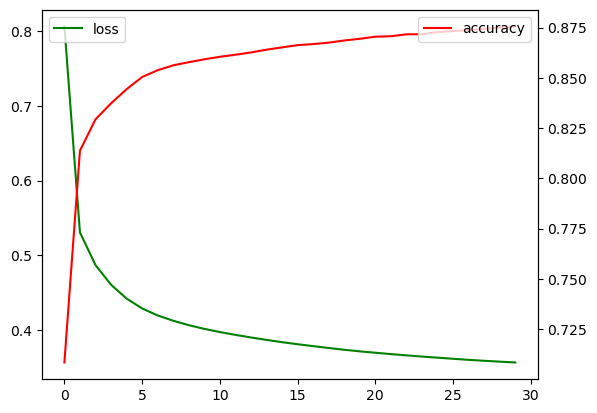

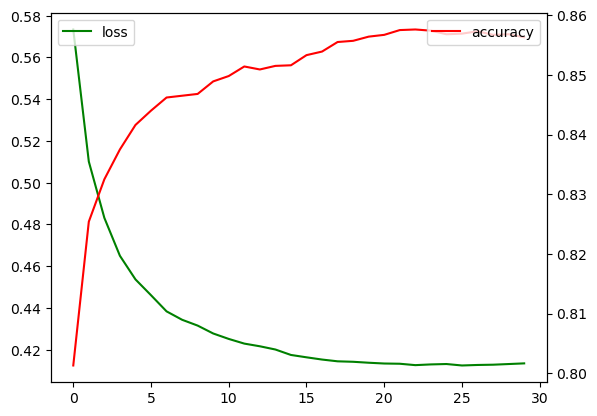

In [147]:
# 지정된 횟수 만큼 처음부터 ~ 끝까지 학습 및 검증 진행 
# 목표 : 최적(Error 최소화)의 W, b를 가진 모델 완성 

# from torch.optim.lr_scheduler import ReduceLROnPlateau
best_valid_loss = float('inf')
patience = 8
imporve_cnt = 0

train_loss_acc = [[],[]]
val_loss_acc = [[],[]]

for eps in range(EPOCHS):
    train_loss, train_acc = training() # 학습
    train_loss_acc[0].append(train_loss)
    train_loss_acc[1].append(train_acc)
    
    valid_loss, val_acc = testing() # 검증 
    val_loss_acc[0].append(valid_loss)
    val_loss_acc[1].append(val_acc)
    
    # print(f"[{eps}/{EPOCHS}] \nTRAIN {sum(train_loss)/len(train_loss)} \nVALID : {sum(valid_loss)/len(valid_loss)}\n\n")
    print(eps)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        imporve_cnt = 0
    else:
        imporve_cnt += 1
        if imporve_cnt > patience:
            print(f"Early stopping at epoch {eps}")
            break
    
            
plt_graph(train_loss_acc)
plt_graph(val_loss_acc)

# predict 진행

In [148]:
def prediction():
    # prediction에는 loss 필요없다
    # 추론 모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 비활성화
    model.eval()
    
    with torch.no_grad():
        # 배치크기 만큼 학습 진행 및 저장 
        pred_acc = []
        for cnt, (feature, target) in enumerate(testDL):
            
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            target = target.squeeze().type(torch.float32)
        
            # 학습 
            pre_target = model(feature)
            # print(f"pre_target => {pre_target.shape}, {pre_target.ndim}D")
            # print(f"target => {target.shape}, {target.ndim}D")
            
            
            acc = (pre_target.max(dim=1).indices == target.max(dim=1).indices).sum() / len(pre_target)
            pred_acc.append(acc)
            
    return np.mean(pred_acc)

In [149]:
p_loss, p_acc = prediction()
print(f"predict loss => {p_loss:.4f}, predict accuracy => {p_acc:.4f}")

predict loss => 0.3953, predict accuracy => 0.8619
